In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import utils

In [2]:
VOCAB_SIZE = 10000
OOV_TOKEN = '<OOV>'
MAX_LENGTH = 120
TRUNCATING = 'post'
PADDING = 'post'
EMBEDDING_DIM = 16
NUM_EPOCHS = 10

In [3]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

In [4]:
train_sentences = []
train_labels = []

val_sentences = []
val_labels = []

for sentence, label in train_data:
    train_sentences.append(sentence.numpy().decode('utf8'))
    train_labels.append(label.numpy())

for sentence, label in test_data:
    val_sentences.append(sentence.numpy().decode('utf8'))
    val_labels.append(label.numpy())

train_labels_final = np.array(train_labels)
val_labels_final = np.array(val_labels)

In [5]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [6]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding=PADDING, truncating=TRUNCATING)

In [7]:
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding=PADDING, truncating=TRUNCATING)

In [8]:
def build_model_lstm():
    model = keras.Sequential([
        keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        keras.layers.Bidirectional(keras.layers.LSTM(32)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_model_gru():
    model = keras.Sequential([
        keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        keras.layers.Bidirectional(keras.layers.GRU(32)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def build_model_conv1d():
    model = keras.Sequential([
        keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        keras.layers.Conv1D(128, 5, activation='relu'),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
model_lstm = build_model_lstm()
model_lstm.summary()
history_lstm = model_lstm.fit(
    train_padded, 
    train_labels_final,
    epochs=NUM_EPOCHS, 
    validation_data=(val_padded, val_labels_final)
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 176,769
Trainable params: 176,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 16s 20ms/step - loss: 0.4517 - accuracy: 0.7759 - val_loss: 0.3807 - val_accuracy: 0.8272
Epoch 2/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2856 - accuracy: 0.8839 - 

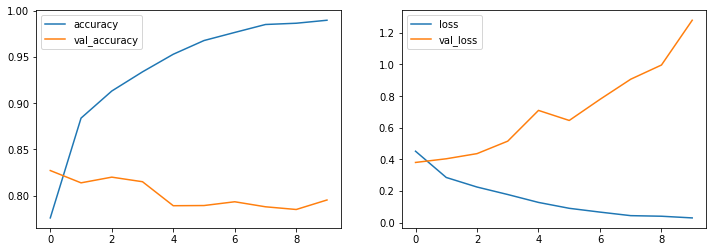

In [10]:
utils.plot_history(history_lstm)

In [11]:
model_gru = build_model_gru()
model_gru.summary()
history_gru = model_gru.fit(
    train_padded, 
    train_labels_final,
    epochs=NUM_EPOCHS, 
    validation_data=(val_padded, val_labels_final)
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 173,825
Trainable params: 173,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 15s 19ms/step - loss: 0.4904 - accuracy: 0.7437 - val_loss: 0.4056 - val_accuracy: 0.8114
Epoch 2/10
782/782 [==============================] - 14s 18ms/step - loss: 0.2972 - accuracy: 0.8767 

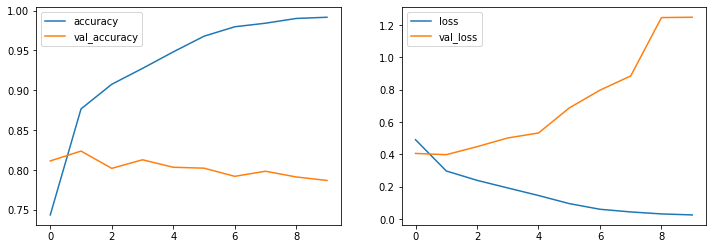

In [12]:
utils.plot_history(history_gru)

In [13]:
model_conv1d = build_model_conv1d()
model_conv1d.summary()
history_conv1d = model_conv1d.fit(
    train_padded, 
    train_labels_final,
    epochs=NUM_EPOCHS, 
    validation_data=(val_padded, val_labels_final)
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 178,689
Trainable params: 178,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 0.4218 - accuracy: 0.7993 - val_loss: 0.

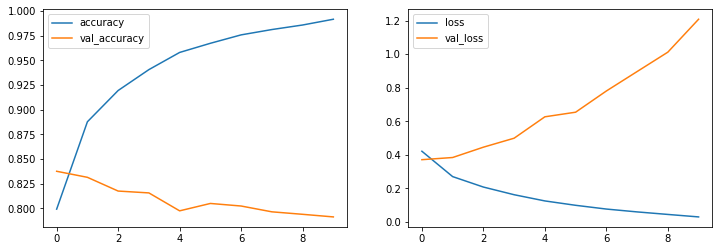

In [14]:
utils.plot_history(history_conv1d)